In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import JAX instead of numpy
import jax.numpy as np
import jax.random as rand
from jax import jit, vmap, grad, value_and_grad

# Import modified version of challenge metrics
from tomo_challenge import jax_metrics as metrics

# Import tools from jax-cosmo
from jax_cosmo.redshift import kde_nz

Found classifier IBandOnly
Found classifier NeuralNetwork
Found classifier Random
Found classifier RandomForest


## Loading the data

In [3]:
from tomo_challenge.data import load_data, load_redshift
from sklearn.preprocessing import StandardScaler, RobustScaler
features_scaler = RobustScaler()

data = load_data('../data/training.hdf5','riz',colors=True, errors=True, array=True)
m = (data[:,0] <29) & (data[:,1] <29) & (data[:,2] <29)
data = data[m]

features = np.clip(np.array(features_scaler.fit_transform(data)),-4,4)
labels = np.array(load_redshift('../data/training.hdf5'))[m]

../tomo_challenge/data.py:76: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [4]:
features.shape

(8552577, 12)

In [5]:
# Let's grab some data
batch_size = 2000

batch_labels = labels[:batch_size]
batch_features = features[:batch_size]

In [8]:
# Let's build an n(z) using a KDE
nz = kde_nz(batch_labels, np.ones_like(batch_labels),  bw=0.01)

Text(0.5, 0, 'redshift z')

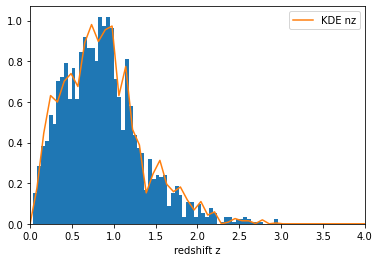

In [9]:
z = np.linspace(0,4)
hist(batch_labels, 64, density=True)
plot(z, nz(z), label='KDE nz')
xlim(0,4)
legend()
xlabel('redshift z')

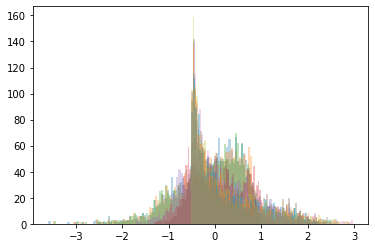

In [10]:
# Checking normalization of features
for i in range(12):
    hist(batch_features[:,i],100, alpha=0.3)

In [11]:
import jax
import jax_cosmo

In [21]:
ell, delta_ell = metrics.ell_binning()

@jax.jit
def FoM_DETF(weights, labels=batch_labels, inds=[5,6]):
    
    # Retrieve the probes
    probes = metrics.get_probes(weights, labels)
    
    # Compute the derivatives of the data vector
    @jax.jit
    def mean(params):
        cosmo = jax_cosmo.Cosmology(
            Omega_c = params[0],
            Omega_b = params[1],
            h = params[2],
            n_s =  params[3],
            sigma8 = params[4],
            Omega_k=0.,
            w0=params[5], wa=params[6]
        )
        return jax_cosmo.angular_cl.angular_cl(cosmo, ell, probes, nonlinear_fn=jax_cosmo.power.halofit)

    # Compute the jacobian of the data vector at fiducial cosmology
    fid_params = np.array([0.27, 0.045, 0.67, 0.96, 0.840484495, -1., 0.])
    jac_mean = jax.jacfwd(lambda x: mean(x).flatten())
    
    mu = mean(fid_params)
    dmu = jac_mean(fid_params)
        
    # Compute the covariance matrix
    cl_noise = jax_cosmo.angular_cl.noise_cl(ell, probes)
    C = jax_cosmo.angular_cl.gaussian_cl_covariance(ell, probes, mu, cl_noise)
    
    invCov = np.linalg.inv(C)
    
    # Compute constant covariance FoM
    t2 = np.einsum('pa,pq,qb->ab', dmu, invCov, dmu)
    F = t2

    # Compute covariance
    i,j = inds
    covmat_chunk = np.linalg.inv(F)[:, [i, j]][[i, j], :]
    
    # And get the FoM, the inverse area of the 2 sigma contour
    # area.
    area = 6.17 * np.pi * np.sqrt(np.linalg.det(covmat_chunk))
    return 1/area

## Create a neural network classifier

In [22]:
from flax import nn
from flax import optim

In [23]:
nbins=2
# Here is a trivial classifier for 2 bins
class BinningNN(nn.Module):
    def apply(self, x):
        """
        Takes as an input the features to use for binning
        """
        net = nn.Dense(x, 500, name='fc1')
        net = nn.leaky_relu(net)
        net = nn.BatchNorm(net)
        net = nn.Dense(net, 500, name='fc2')
        net = nn.leaky_relu(net)
        net = nn.BatchNorm(net)
        net = nn.Dense(net, 500, name='fc3')
        net = nn.leaky_relu(net)
        net = nn.BatchNorm(net)
        # The output of the model should be a gumbell softmax layer
        return nn.softmax(nn.Dense(net, nbins))

In [24]:
@jit
def train_step(optimizer, batch):
    def loss_fn(model):
        w = model(batch['features'])
        
        return 1./FoM_DETF(w, batch['labels'])
    loss, g = value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(g)
    return optimizer, loss

In [25]:
# Let's get some initial weights
_, initial_params = BinningNN.init_by_shape( rand.PRNGKey(0), [((1, 12), np.float32)])
model = nn.Model(BinningNN, initial_params)

In [26]:
optimizer = optim.Adam(learning_rate=0.001).create(model)

In [27]:
import numpy as onp
batch_size = 5000
def get_batch():
    inds = onp.random.choice(len(labels), batch_size)
    return {'labels': labels[inds], 'features': features[inds]}

In [28]:
losses = []

In [29]:
for i in range(1000):
    batch = get_batch()
    optimizer, loss = train_step(optimizer, batch)
    losses.append(loss)
    if i%10 == 0:
        print('Loss : %f'%loss)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Loss : 0.082741
Loss : 0.034619
Loss : 0.032469
Loss : 0.030701
Loss : 0.029780
Loss : 0.029895
Loss : 0.028904
Loss : 0.028402
Loss : 0.029422
Loss : 0.028546
Loss : 0.028567
Loss : 0.028745
Loss : 0.029307
Loss : 0.029505
Loss : 0.028731
Loss : 0.029062
Loss : 0.029456
Loss : 0.028111
Loss : 0.029254
Loss : 0.029030
Loss : 0.028546
Loss : 0.028672
Loss : 0.028209
Loss : 0.028525
Loss : 0.028569
Loss : 0.028465
Loss : 0.028751
Loss : 0.028193
Loss : 0.027388
Loss : 0.028440
Loss : 0.028882
Loss : 0.028365
Loss : 0.027255
Loss : 0.029375
Loss : 0.027457
Loss : 0.027656
Loss : 0.027917
Loss : 0.028244
Loss : 0.027760
Loss : 0.027672
Loss : 0.028509
Loss : 0.028216
Loss : 0.026999
Loss : 0.027938
Loss : 0.027820
Loss : 0.027959
Loss : 0.028084
Loss : 0.027936
Loss : 0.028269
Loss : 0.027375
Loss : 0.027988
Loss : 0.028952
Loss : 0.027801
Loss : 0.027517
Loss : 0.028212
Loss : 0.028704
Loss : 0.027859
Loss : 0.028038
Loss : 0.027359
Loss : 0.027605
Loss : 0.027820
Loss : 0.028344
Loss : 0

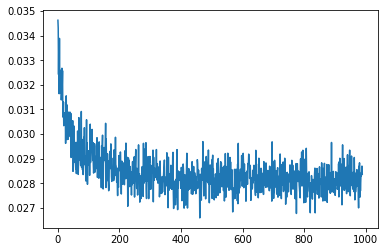

In [30]:
plot(losses[10:])

In [31]:
# Sweet :-D let's see if it did anything
w  = optimizer.target(batch['features'])
nzs = [kde_nz(batch['labels'], w[:,i], bw=0.05, zmax=4.) for i in range(nbins)]

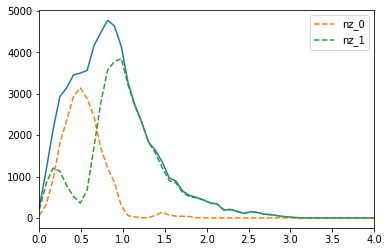

In [32]:
#figure(figsize=(13,7))
z = np.linspace(0,4)
nz_total = kde_nz(batch['labels'], np.ones_like(batch['labels']), bw=0.05)
plot(z, nz_total(z)*len(nz_total.params[0]))
for i, nz in enumerate(nzs):
    plot(z, nz(z)*nz.params[1].sum(), '--', label='nz_%d'%i)
xlim(0,4)
legend()

In [70]:
# Exporting the trained model
from flax import serialization
import pickle

with open('BinningNN_3x2_2b_FoM_DETF.pckl', 'wb') as file:
    pickle.dump(serialization.to_bytes(optimizer.target), file)